In [21]:
%matplotlib inline
import mhkit
import gridstatus
import numpy as np
import pandas as pd
import requests
import io
import matplotlib.pyplot as plt
import PySAM.Pvwattsv8 as pv

In [22]:
# NDBC data
ndbc_data_file = 'NDBC-46022-2021-spectrum.txt'
# downloaded from https://www.ndbc.noaa.gov/download_data.php?filename=46022w2021.txt.gz&dir=data/historical/swden/
[wave_data,meta] = mhkit.wave.io.ndbc.read_file(ndbc_data_file)
depth = 419 # m
J = mhkit.wave.resource.energy_flux(wave_data.T,depth) # energy flux, W/m


In [23]:
# SAM wave 3-hourly data
url = 'https://raw.githubusercontent.com/NREL/SAM/develop/deploy/wave_resource_ts/lat40.84_lon-124.25__2010.csv'
download = requests.get(url).content
file = io.StringIO(download.decode('utf-8'))
parser = lambda y,m,d,H,M: pd.datetime.strptime(f"{y}.{m}.{d}.{H}.{M}", "%Y.%m.%d.%H.%M")

wave_data_2 = pd.read_csv(file, skiprows = 2, parse_dates={"Time":[0,1,2,3,4]}, date_parser=parser)
wave_data_2 = wave_data_2[['Time','Significant Wave Height','Energy Period']].set_index("Time")
wave_data_2.index = wave_data_2.index.tz_localize('US/Pacific') + pd.offsets.DateOffset(years=11) # fake it starting in 2021
wave_data_2.head()

,Significant Wave Height,Energy Period
Time,,
2021-01-01 00:00:00-08:00,3.21103,9.0149
2021-01-01 03:00:00-08:00,3.13325,9.2803
2021-01-01 06:00:00-08:00,3.32286,8.8879
2021-01-01 09:00:00-08:00,3.35948,8.8694
2021-01-01 12:00:00-08:00,3.33115,9.3399


In [24]:
# Wave energy time series calculation
rho = 1025
g = 9.8
coeff = rho*(g**2)/(64*np.pi)
wave_data_2["J"] = coeff*wave_data_2["Significant Wave Height"]**2*wave_data_2["Energy Period"]
CW = 10 # capture width of WEC, m
wave_data_2["P"] = wave_data_2["J"] * CW # power of WEC, W

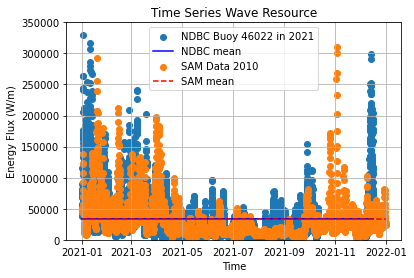

In [232]:
# plot NDBC data alongside SAM data
fig, ax = plt.subplots()

ax.scatter(J.index, J["J"], label='NDBC Buoy 46022 in 2021')
ax.plot(J.index, np.full(np.shape(J.index),J.mean(axis=0)), c='blue', label='NDBC mean')

#plt.xlim([J.index[0], J.index[24]])
plt.ylim([0, 350000])
ax.scatter(wave_data_2.index, wave_data_2["J"], label='SAM Data 2010')
ax.plot(wave_data_2.index, np.full(np.shape(wave_data_2["J"]),wave_data_2["J"].mean(axis=0)), '--', c='red', label='SAM mean')

ax.legend()
ax.set(xlabel='Time', ylabel='Energy Flux (W/m)', title='Time Series Wave Resource')
ax.grid()


In [26]:
# CAISO data
caiso = gridstatus.CAISO()
start = pd.Timestamp("Jan 1, 2021").normalize()
end = pd.Timestamp("Dec 31, 2021").normalize()
#lmp = caiso.get_lmp(start=start, end=end, market='REAL_TIME_HOURLY', 
#                    locations=["EUREKAA_6_N001"])
lmp = pd.read_csv('lmp-eureka-2021.csv',index_col=1)
lmp.index = pd.to_datetime(lmp.index,utc=True).tz_convert('US/Pacific')


(0.0, 50.0)

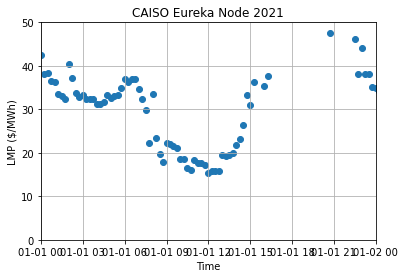

In [237]:
# plot CAISO data
fig, ax = plt.subplots()
ax.scatter(lmp.index, lmp["LMP"])
ax.set(xlabel='Time', ylabel='LMP ($/MWh)', title='CAISO Eureka Node 2021')
ax.grid()
plt.xlim([lmp.index[0], lmp.index[24*4]])
plt.ylim([0,50])

In [195]:
# Get solar and wind data
# for now just copy wave data
solar_data = wave_data_2
wind_data = wave_data_2

file = 'imperial_ca_32.835205_-115.572398_psmv3_60_tmy.csv'
# downloaded from https://raw.githubusercontent.com/NREL/SAM/patch/deploy/solar_resource/imperial_ca_32.835205_-115.572398_psmv3_60_tmy.csv

system_model = pv.default("PVWattsNone")
system_model.SolarResource.solar_resource_file = file
system_model.execute()
energy = system_model.value('annual_energy_distribution_time')

# plot daily power
fig, ax = plt.subplots()
for year in range(0,len(energy)):
    ax.scatter(energy[0],energy[year],color=plt.cm.rainbow(year/len(energy)))
ax.set(xlabel='Day', ylabel='Power (kW)', title='SAM Daily Power Data')
ax.grid()
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0,vmax=len(energy)), cmap='rainbow'),ax=ax,label='Hour of Day')

,P
2021-01-01 00:00:00-08:00,0.000000e+00
2021-01-01 00:00:00-08:00,0.000000e+00
2021-01-01 00:00:00-08:00,0.000000e+00
2021-01-01 00:00:00-08:00,0.000000e+00
2021-01-01 00:00:00-08:00,0.000000e+00
2021-01-01 00:00:00-08:00,0.000000e+00
2021-01-01 00:00:00-08:00,0.000000e+00
2021-01-01 00:00:00-08:00,1.341493e+07
2021-01-01 00:00:00-08:00,3.661477e+07
2021-01-01 00:00:00-08:00,5.238607e+07


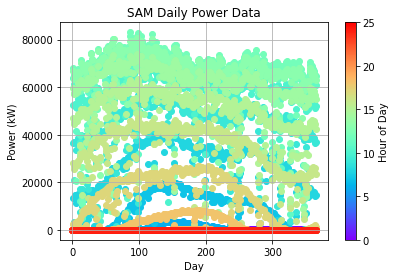

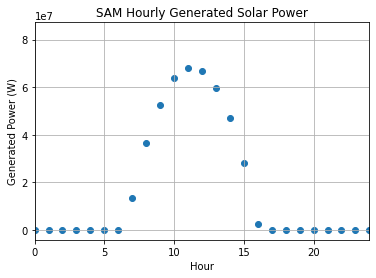

In [195]:
# plot hourly generated power
gen = system_model.value('ac')
fig, ax = plt.subplots()
ax.scatter(range(0,len(gen)),gen)
ax.set(xlabel='Hour', ylabel='Generated Power (W)', title='SAM Hourly Generated Solar Power')
ax.grid()
plt.xlim([0, 24])

time = pd.date_range(pd.datetime(2021,1,1), freq='H', periods=len(gen)).normalize().tz_localize('US/Pacific')
solar_data = pd.DataFrame(gen,index=time,columns=["P"])
solar_data.head(10)

In [230]:
# Create overall dataframe with all resources resampled onto consistent times,
# accounting for different end times across datasets

dfs = [lmp, wave_data_2, solar_data, wind_data]
# todo: something is wrong with the interpolation!
dfs_resampled = [df.resample('15min').mean().interpolate() for df in dfs]
#print(dfs_resampled)

end_times = [df.index[-1] for df in dfs_resampled]
idx = np.argmin(end_times)
df = pd.DataFrame(index=dfs_resampled[idx].index)

df["LMP ($/MWh)"] = dfs_resampled[0]["LMP"]
df["Wave power (W)"] = dfs_resampled[1]["P"]
df["Solar power (W)"] = dfs_resampled[2]["P"]
df["Wind power (W)"] = dfs_resampled[3]["P"]
df.tail()

(18628.333333333332, 18629.333333333332)

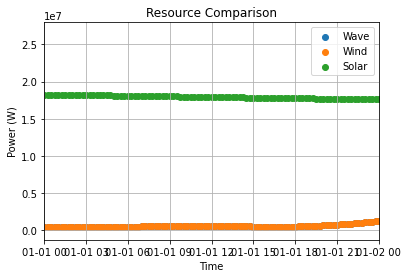

In [230]:
# plot resampled data to confirm interpolation works
resources = ['Wave','Wind','Solar']
powers = [r + ' power (W)' for r in resources]

fig, ax = plt.subplots()
for i in range(0,len(resources)):
    ax.scatter(df.index, df[powers[i]], label=resources[i])
ax.set(xlabel='Time', ylabel='Power (W)', title='Resource Comparison')
ax.grid()
ax.legend()
plt.xlim([df.index[0], df.index[4*24]])

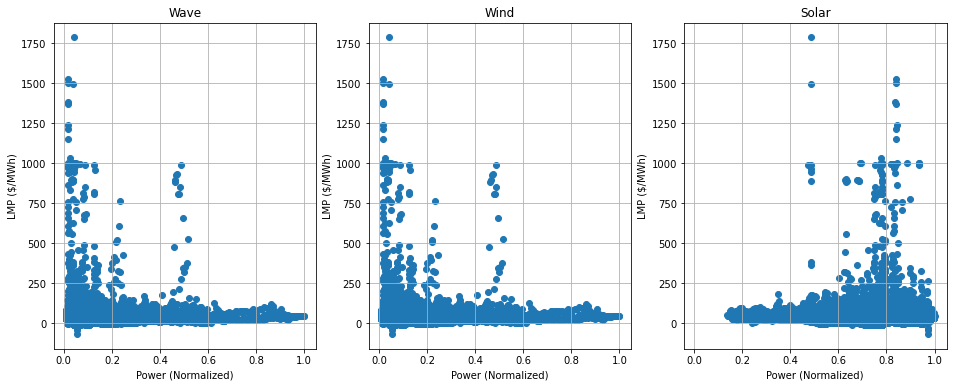

In [238]:
# scatterplot correlation between production and price

fig, axs = plt.subplots(ncols=len(resources),sharex=True,figsize=(16,6))
for i in range(0,len(resources)):
    axs[i].scatter(df[powers[i]]/df[powers[i]].max(), df["LMP ($/MWh)"])
    axs[i].set(xlabel='Power (Normalized)', ylabel='LMP ($/MWh)', title=resources[i])
    axs[i].grid()
fig.suptitle = 'Correlation between production and price'

In [239]:
# value of each energy source
W_to_MWh = 15/60 * 10**-6 # for 15min timestep
revenue = W_to_MWh * np.dot(df[powers].T, df["LMP ($/MWh)"])
energy = W_to_MWh * df[powers].sum()
energy.reset_index(drop=True,inplace=True)
value = np.divide(revenue,energy)

output = pd.DataFrame(np.vstack([revenue,energy,value]).T, index=resources, columns=['Yearly Revenue ($)','Yearly Energy (MWh)','Value ($/MWh)'])
output['Yearly Revenue ($)'] = output['Yearly Revenue ($)'].map(lambda x: f"${x:,.2f}") # format as currency
print(output)


      Yearly Revenue ($)  Yearly Energy (MWh)  Value ($/MWh)
Wave         $141,466.95          2917.309403      48.492267
Wind         $141,466.95          2917.309403      48.492267
Solar      $9,044,598.96        177715.292243      50.893757
